# AutoEncoder on Fashion MNIST Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K

## Parameters

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 64
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 20

## Dataset Preparation and visualization

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [4]:
def preprocess(imgs):
    
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

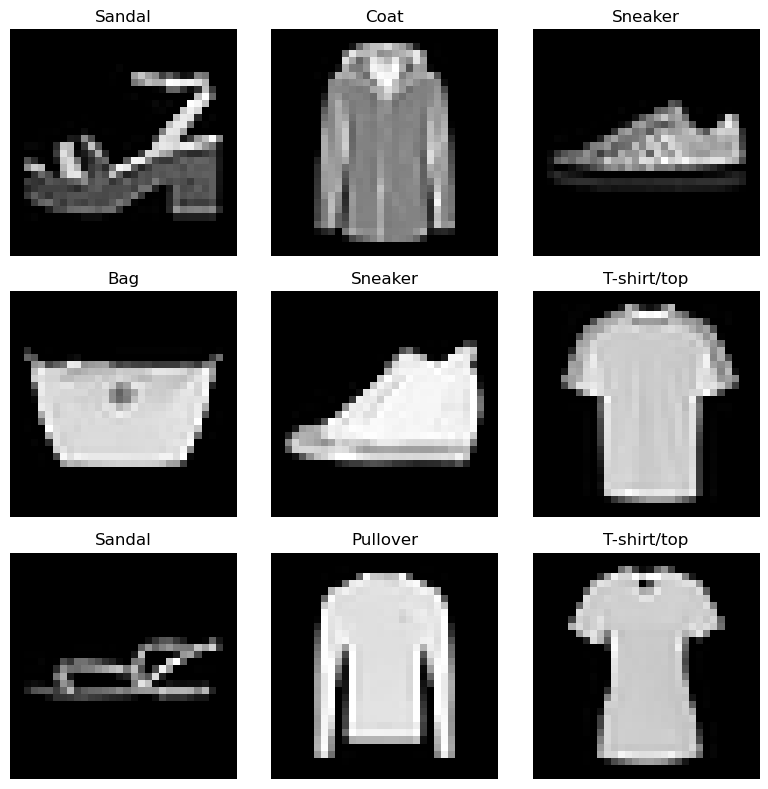

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i in range(9):
    index = np.random.randint(0, len(x_train))  
    axes[i].imshow(x_train[index], cmap='gray')  
    axes[i].set_title(class_names[y_train[index]]) 
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

## AutoEncoder Architechture

In [6]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:] 

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96,770
Trainable params: 96,770
Non-trainable p

In [7]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       1846

In [8]:
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
 model_1 (Functional)        (None, 32, 32, 1)         2462

## Training

In [9]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [10]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="D:\\Gen ai\\Lab\\Autoencoder",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/20
938/938 [==============================] - ETA: 0s - loss: 0.2798

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 12s 11ms/step - loss: 0.2798 - val_loss: 0.2594
Epoch 2/20
935/938 [============================>.] - ETA: 0s - loss: 0.2543

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2543 - val_loss: 0.2538
Epoch 3/20
938/938 [==============================] - ETA: 0s - loss: 0.2515

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2515 - val_loss: 0.2516
Epoch 4/20
932/938 [============================>.] - ETA: 0s - loss: 0.2497

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 11ms/step - loss: 0.2497 - val_loss: 0.2513
Epoch 5/20
933/938 [============================>.] - ETA: 0s - loss: 0.2487

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2487 - val_loss: 0.2497
Epoch 6/20
934/938 [============================>.] - ETA: 0s - loss: 0.2478

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2478 - val_loss: 0.2496
Epoch 7/20
935/938 [============================>.] - ETA: 0s - loss: 0.2471

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 11ms/step - loss: 0.2471 - val_loss: 0.2488
Epoch 8/20
936/938 [============================>.] - ETA: 0s - loss: 0.2466

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2466 - val_loss: 0.2482
Epoch 9/20
932/938 [============================>.] - ETA: 0s - loss: 0.2460

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2460 - val_loss: 0.2479
Epoch 10/20
937/938 [============================>.] - ETA: 0s - loss: 0.2456

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2456 - val_loss: 0.2478
Epoch 11/20
938/938 [==============================] - ETA: 0s - loss: 0.2452

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2452 - val_loss: 0.2477
Epoch 12/20
934/938 [============================>.] - ETA: 0s - loss: 0.2448

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2448 - val_loss: 0.2473
Epoch 13/20
937/938 [============================>.] - ETA: 0s - loss: 0.2445

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2445 - val_loss: 0.2477
Epoch 14/20
932/938 [============================>.] - ETA: 0s - loss: 0.2441

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2441 - val_loss: 0.2465
Epoch 15/20
937/938 [============================>.] - ETA: 0s - loss: 0.2438

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 11ms/step - loss: 0.2438 - val_loss: 0.2472
Epoch 16/20
936/938 [============================>.] - ETA: 0s - loss: 0.2435

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 10s 11ms/step - loss: 0.2435 - val_loss: 0.2463
Epoch 17/20
937/938 [============================>.] - ETA: 0s - loss: 0.2433

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 12ms/step - loss: 0.2433 - val_loss: 0.2464
Epoch 18/20
935/938 [============================>.] - ETA: 0s - loss: 0.2430

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 12ms/step - loss: 0.2430 - val_loss: 0.2461
Epoch 19/20
935/938 [============================>.] - ETA: 0s - loss: 0.2428

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 11ms/step - loss: 0.2428 - val_loss: 0.2455
Epoch 20/20
933/938 [============================>.] - ETA: 0s - loss: 0.2427

INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


INFO:tensorflow:Assets written to: D:\Gen ai\Lab\Autoencoder\assets


938/938 [==============================] - 11s 12ms/step - loss: 0.2426 - val_loss: 0.2461


In [12]:
autoencoder.save("D:/Gen ai/Lab/Autoencoder/models/autoencoder.keras")
encoder.save("D:/Gen ai/Lab/Autoencoder/models/encoder.keras")
decoder.save("D:/Gen ai/Lab/Autoencoder/models/decoder.keras")

## Reconstruction 

In [13]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [14]:
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 1s 5ms/step


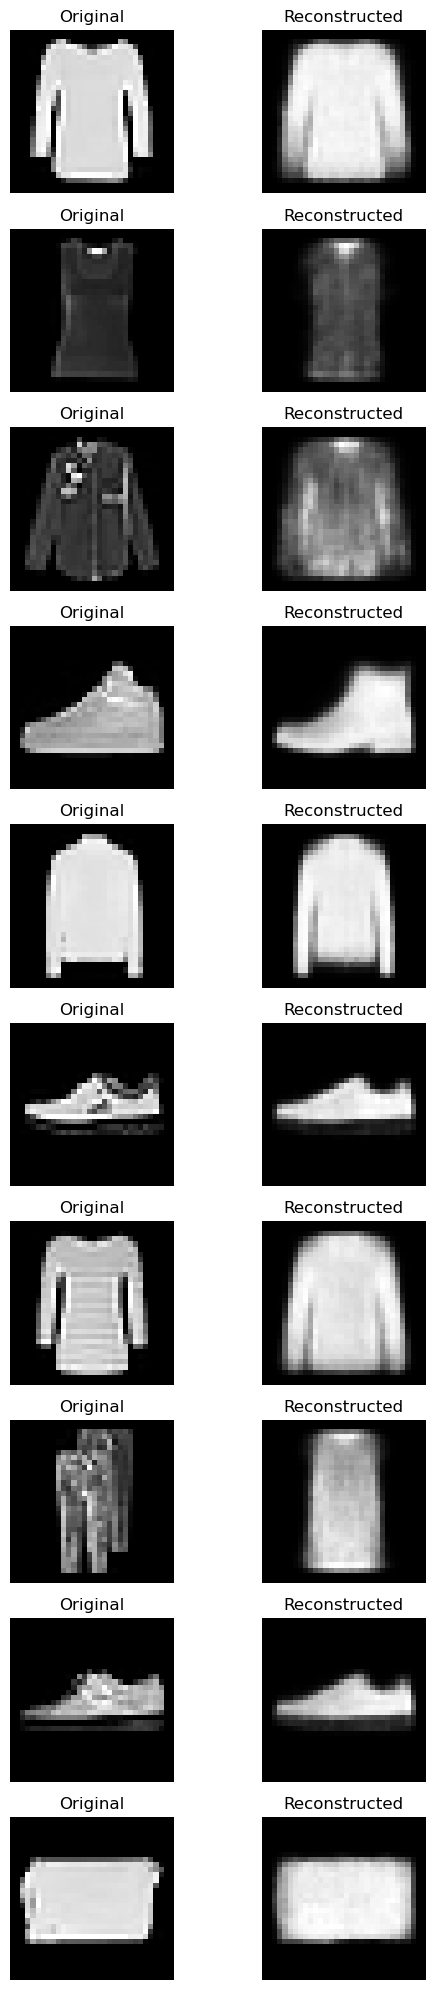

In [15]:
n_samples = 10 
fig, axes = plt.subplots(n_samples, 2, figsize=(6, 2 * n_samples))

for i in range(n_samples):
    index = np.random.randint(0, n_to_predict)  
    
    axes[i, 0].imshow(example_images[index], cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(predictions[index], cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
embeddings = encoder.predict(example_images)

157/157 [==============================] - 0s 2ms/step


In [17]:
print(embeddings[:10])

[[-1.4995828  -0.40209058]
 [ 4.0839      0.9164534 ]
 [ 2.599618   -8.006626  ]
 [ 0.9420211  -4.874056  ]
 [ 1.2146349   0.5843463 ]
 [ 2.9753914  -6.9002104 ]
 [ 0.74118507 -0.27503324]
 [ 1.0802954   0.13185306]
 [-1.5604745  -3.932281  ]
 [-2.3644142  -2.9261012 ]]


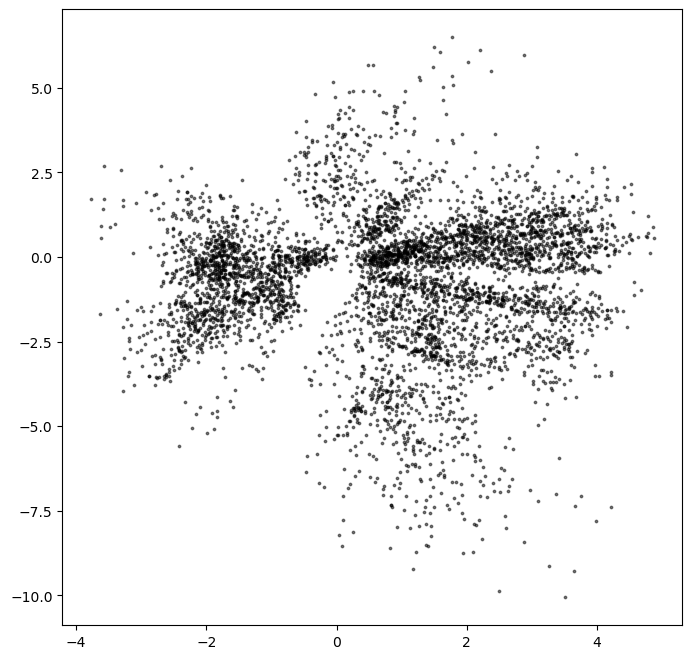

In [18]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

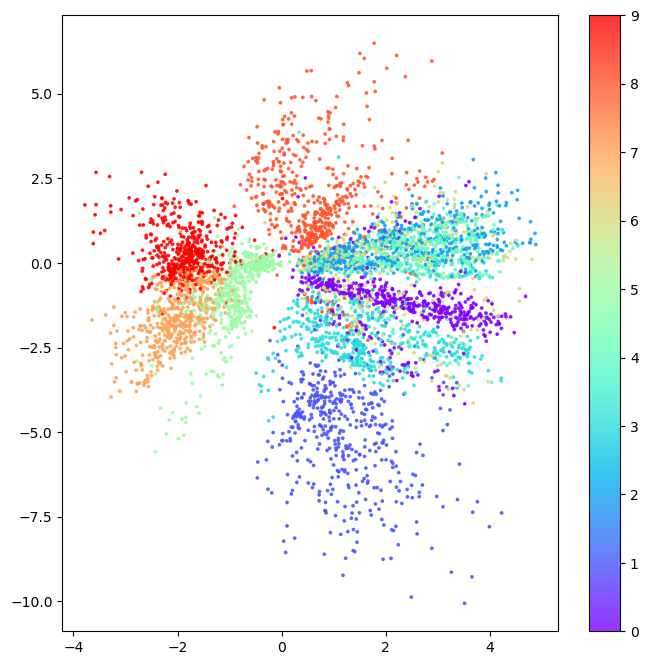

In [19]:
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In [20]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [21]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 299ms/step


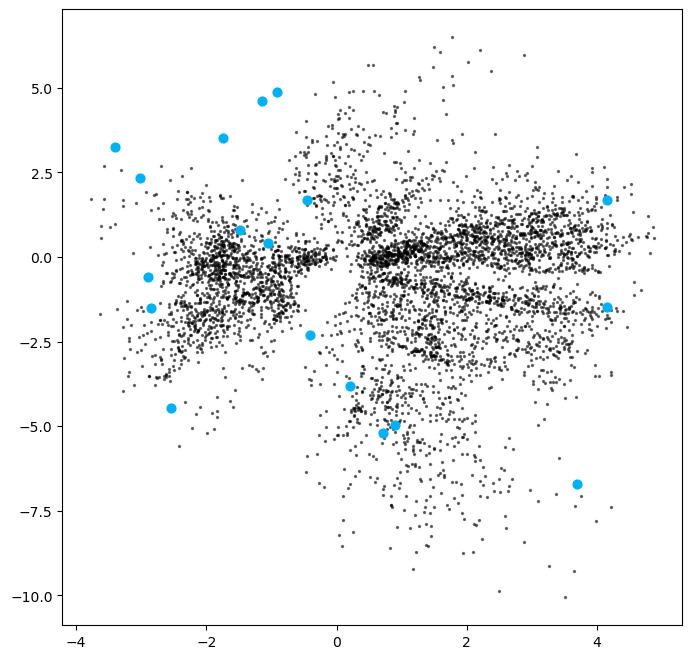

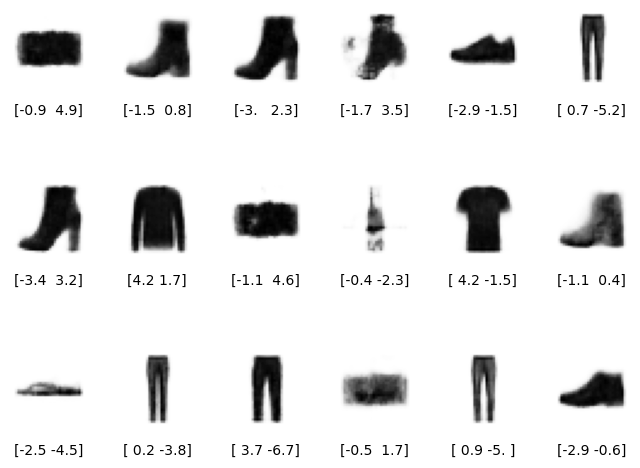

In [22]:
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")